In [59]:
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import pickle

# mpl cosmetics
import matplotlib as mpl
from matplotlib.lines import lineMarkers
from matplotlib.colors import BASE_COLORS
import matplotlib.patches as mpatches
lineMarkers = tuple(lineMarkers.keys())
baseColors = tuple(BASE_COLORS.keys())

In [60]:
def read_file(fname:str) -> tuple:
    data = ()
    with open(fname,mode="rb") as res_file:
        while True:
            try:
                sim_data = pickle.load(res_file)
                data += (sim_data,)

            except EOFError:
                print("File " + fname + " is over.")
                break
    return data

def gateset_string(gate_set:tuple) -> str:
    gate_str = "{" + gate_set[0]
    for i in range(1,len(gate_set)):
        gate_str += ("," + gate_set[i])
    gate_str += "}"
    return gate_str

In [61]:
# reading the data from the pickled file
therm_data = ()
gate_sets = ()

# thermalization for different gate sets
therm_data += read_file("data/06-29_01-54-34___data.pickle")
therm_data += read_file("data/06-29_01-55-08___data.pickle")
therm_data += read_file("data/06-29_01-55-15___data.pickle")

# thermalization for different (inverse) temperatures beta
beta_data = read_file("data/06-29_01-59-54___data.pickle")

File data/06-29_01-54-34___data.pickle is over.
File data/06-29_01-55-08___data.pickle is over.
File data/06-29_01-55-15___data.pickle is over.
File data/06-29_01-59-54___data.pickle is over.


In [62]:
# finding the gate sets we simulated
gate_sets = ()
for dataset in therm_data:
    if dataset["gate_set"] not in gate_sets: gate_sets += (dataset["gate_set"],)

# finding the values of beta
beta_axis = ()
for dataset in beta_data:
    if dataset["cooling"]["beta"] not in beta_axis: beta_axis += (dataset["cooling"]["beta"],)

# finding the numbers of wires
nWires_axis = ()
for dataset in therm_data:
    if dataset["heating"]["nWires"] not in nWires_axis: nWires_axis += (dataset["heating"]["nWires"],)

# Plots for thermalization

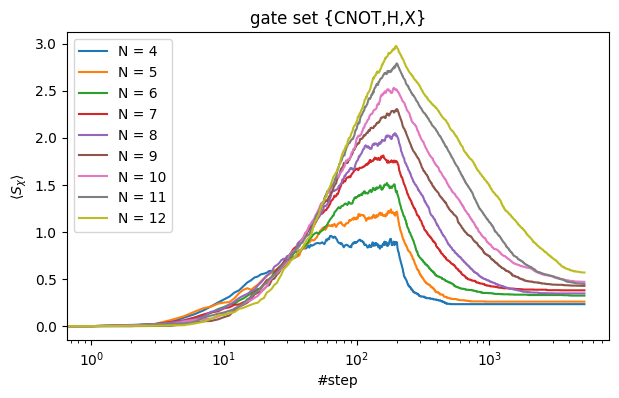

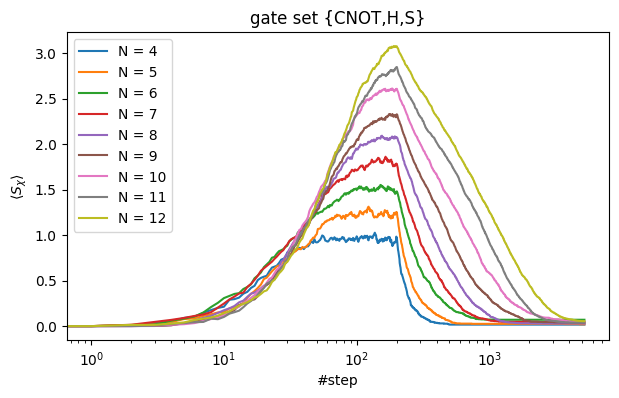

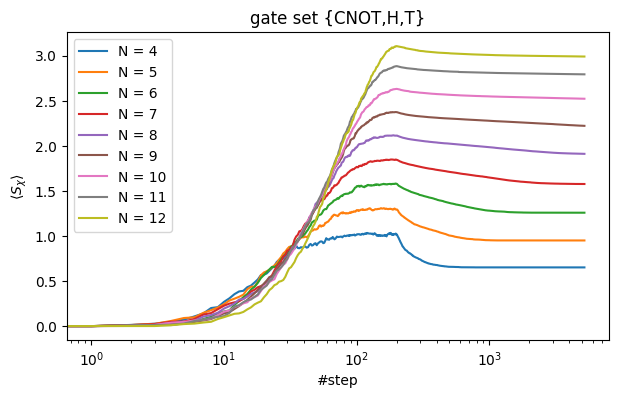

In [63]:
for gate_set in gate_sets:
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(7,4))
    for dataset in therm_data:
        if dataset["gate_set"] == gate_set:
            step_axis = np.arange(dataset["heating"]["nSteps"]+dataset["cooling"]["nSteps"]+2)
            ax.plot(step_axis,np.concatenate((dataset["singvals_heating"].mean(axis=1),dataset["singvals_cooling"].mean(axis=1))),label="N = {}".format(dataset["heating"]["nWires"]))
    ax.set_xlabel("#step")
    ax.set_xscale("log")
    ax.set_title("gate set " + gateset_string(gate_set))
    ax.set_ylabel(r"$\langle S_{\chi}\rangle$")
    ax.legend(loc="upper left")
    fig.savefig("writing/plots/therm_" + gateset_string(gate_set) + ".pdf",bbox_inches="tight")

# Plots for different temperatures $\beta$

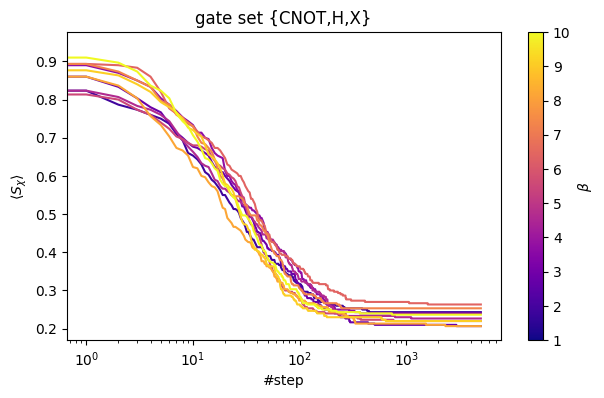

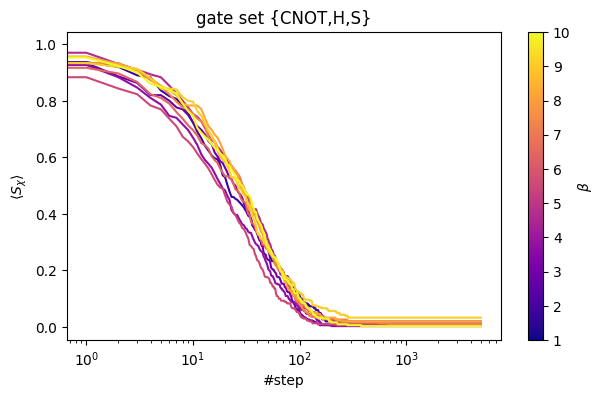

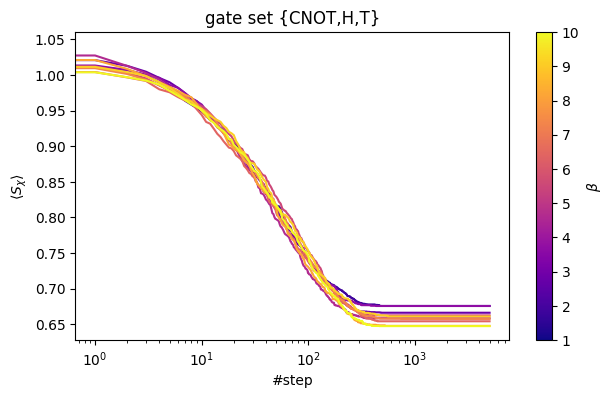

In [64]:
cmap = mpl.colormaps["plasma"]

for gate_set in gate_sets:
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(7,4))
    for dataset in beta_data:
        if dataset["gate_set"] == gate_set:
            step_axis = np.arange(dataset["cooling"]["nSteps"]+1)
            ax.plot(
                step_axis,
                dataset["singvals_cooling"].mean(axis=1),
                label=r"$\beta$ = {}".format(dataset["cooling"]["beta"]),
                c=cmap(dataset["cooling"]["beta"] / max(beta_axis))
            )
    ax.set_xlabel("#step")
    ax.set_xscale("log")
    ax.set_title("gate set " + gateset_string(gate_set))
    ax.set_ylabel(r"$\langle S_{\chi}\rangle$")
    fig.colorbar(plt.cm.ScalarMappable(mpl.colors.Normalize(vmin=min(beta_axis),vmax=max(beta_axis)),cmap="plasma"),ax=ax,label=r"$\beta$")
    fig.savefig("writing/plots/betatest_" + gateset_string(gate_set) + ".pdf",bbox_inches="tight")

# Effect of system size on thermalization

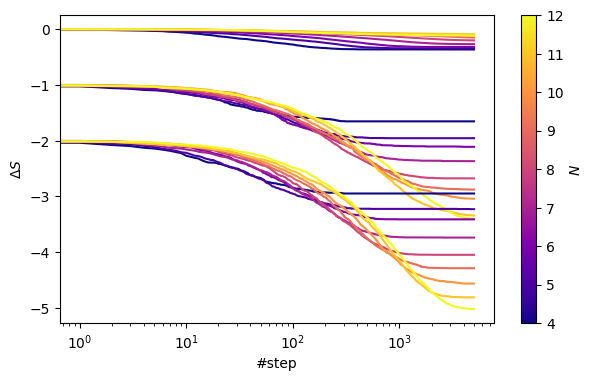

In [79]:
# starting value of mean entanglement entropy at the beginning of the cooling procedure, for each gate set
S0 = {}
for dataset in therm_data:
    if dataset["gate_set"] not in S0.keys(): S0[dataset["gate_set"]] = {}
    S0[dataset["gate_set"]][dataset["heating"]["nWires"]] = dataset["singvals_cooling"].mean(axis=1)[0]

cmap = mpl.colormaps["plasma"]

gate_set_offsets = {('CNOT', 'H', 'S'):-2,('CNOT', 'H', 'X'):-1,('CNOT', 'H', 'T'):0}

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(7,4))
for dataset in therm_data:
    step_axis = np.arange(dataset["cooling"]["nSteps"]+1)
    ax.plot(
        step_axis,
        dataset["singvals_cooling"].mean(axis=1) - S0[dataset["gate_set"]][dataset["heating"]["nWires"]] + gate_set_offsets[dataset["gate_set"]],
        label="N = {}".format(dataset["heating"]["nWires"]),
        c=cmap((dataset["heating"]["nWires"] - min(nWires_axis)) / (max(nWires_axis) - min(nWires_axis)))
    )
ax.set_xlabel("#step")
ax.set_ylabel(r"$\Delta S$")
ax.set_xscale("log")
# ax.legend()
fig.colorbar(plt.cm.ScalarMappable(mpl.colors.Normalize(vmin=min(nWires_axis),vmax=max(nWires_axis)),cmap="plasma"),ax=ax,label=r"$N$")
fig.savefig("writing/plots/therm_speed.pdf",bbox_inches="tight")